# Introduction to PyTorch Geometric

> PyTorch Geometric (PyG) is a library built upon PyTorch to easily write and train Graph Neural Networks (GNNs) for a wide range of applications related to structured data.

> It consists of various methods for deep learning on graphs and other irregular structures, also known as geometric deep learning, from a variety of published papers. In addition, it consists of easy-to-use mini-batch loaders for operating on many small and single giant graphs, multi GPU-support, distributed graph learning via Quiver, a large number of common benchmark datasets (based on simple interfaces to create your own), the GraphGym experiment manager, and helpful transforms, both for learning on arbitrary graphs as well as on 3D meshes or point clouds.

Source: https://pytorch-geometric.readthedocs.io/en/latest/

This tutorial assumes prior rudimentary understanding of PyTorch. In this tutorial, we will understand how PyTorch Geometric handles graph data and relate to familiar concepts from PyTorch (such as Datasets and Dataloaders).

Material inspired by official [PyG tutorials](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html)

### Outline

**Part I:**

- Representation of graphs (10mins)
  - Handling graph data
- Exploring datasets (5mins)
  - Cora
  - ENZYMES
- Minibatching and Dataloaders (5mins)
- Data Transforms (5mins)
  - ModelNet: mesh-to-pointcloud, mesh-to-graph

**Part II:**

- Recap of Graph Neural Networks (10mins)

**Part III:**

- Layer Implementation (10mins)
  - GCN
  - EdgeConv
- Node classification on Cora (10mins)

In [ ]:
!pip uninstall -y torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu113.html

!pip install trimesh

In [ ]:
!import inspect
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as gnn

from torch_geometric.data import Data

import trimesh

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

# Representation of graphs

A graph $\mathbf{G}$ consists of a set of nodes $\mathbf{V} = \{V_1, V_2, \ldots, V_n\}$ and a set of edges $\mathbf{I} \subseteq \mathbf{V} \times \mathbf{V}$. Let the number of nodes and edges in the graph be denoted by $N$ and $M$ respectively.

Every node $v_i$ can be represented by a vector of node features $x_i$. The node features can be stacked to form a matrix $\mathbf{X}$.

$$\mathbf{X} = (x_1, x_2, \ldots, x_N)^\mathbf{T}$$

Every edge can be represented with a set of features $e_i$. The edge features can be stacked to form a matrix $\mathbf{E}$.

$$\mathbf{\mathbf{E}} = (e_1, e_2, \ldots, e_M)^\mathbf{T}$$

Not all graphs have both node features and edge features; some have both and some have only one of them.

Note that by stacking node features into a matrix, we're implicitly ordering the nodes ("first" row represents the "first" node's feature vector). Although we have an ordering in our representation, the functions (like neural network layers) that operate on these numerical representations will be invariant (like pooling operating) or equivariant (like graph convolution) to the ordering of the nodes.

**Permutation invariant operation (without edge features):**

The result of the function does not change on reordering, i.e. it is invariant to the order.

$f(\mathbf{PX}, \mathbf{PAP^T}) = f(\mathbf{X}, \mathbf{A})$

where $\mathbf{P}$ is a [permutation matrix](https://en.wikipedia.org/wiki/Permutation_matrix) and $\mathbf{A}$ is the [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix).

**Permutation equivariant operation (without edge features):**

Reordering the nodes in the arguments result in the same reordering of results of otherwise identical result.

$f(\mathbf{PX}, \mathbf{PAP^T}) = Pf(\mathbf{X}, \mathbf{A})$

where $\mathbf{P}$ is a [permutation matrix](https://en.wikipedia.org/wiki/Permutation_matrix) and $\mathbf{A}$ is the [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix).

# Handling graph data in PyG

A graph in PyG is represented by an instance of [`torch_geometric.data.Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data). `Data` objects have the following attributes:

```
data.x: node feature matrix of shape [num_nodes, num_node_features]
data.edge_index: matrix of edge (u, v) transposed; [2, num_edges]
data.edge_attr: edge features of shape [num_edges, num_edge_features]
data.y: target for the graph; this can be single value or per-node value
```

> None of these attributes are required. In fact, the `Data` object is not even restricted to these attributes. We can, e.g., extend it by `data.face` to save the connectivity of triangles from a 3D mesh in a tensor with shape `[3, num_faces]` and type `torch.long`.

Source: https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html

### Example

We have to construct the `Data` object that describes the graph given below. A node ordering for the representation is provided inside the *node*. The node features $x_i$ are explicitly marked. There are no edge features.

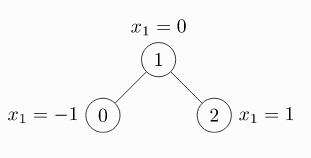

In [ ]:
# the given graph is an undirected graph; we must add an entry for each direction of the edge
edge_index = torch.tensor([
    [0, 1, 1, 2],
    [1, 0, 2, 1]], dtype=torch.long
)

# same as above but here you use a list of edge tuples
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long).T

x = torch.tensor([[-1], [0], [1]], dtype=torch.float32)

data = Data(x=x, edge_index=edge_index)
print(data)

In [ ]:
print("data keys:", data.keys)
print("node features:", data['x'])
print()

print("are there edge features:", "edge_attr" in data)
print("number of nodes:", data.num_nodes)
print("number of edges:", data.num_edges)
print("number of node features:", data.num_node_features)
print("number of edge features:", data.num_edge_features)
print()

print("isolated nodes:", data.has_isolated_nodes())
print("self loops:", data.has_self_loops())
print("is directed graph:", data.is_directed())

### Practice Problem

**Formulation:** We're training a graph neural network to regress the formation energy of small molecules. Suppose our atom vocabulary consists of two atoms: `{N, H}`. Let us represent the node features of the two atoms with one-hot encoding: `N` and `H` be represented by `(0, 1)` and `(1, 0)` respectively. The edge features will have the bond length.

**Question:** Construct a `Data` object for $N_2H_4$ molecule (image given below) based on the given description. The bond length of the `N-N` and `N-H` bonds are `0.147 nm` and `0.1nm` respectively. The formation energy of the molecule is `110 kj/mol`.

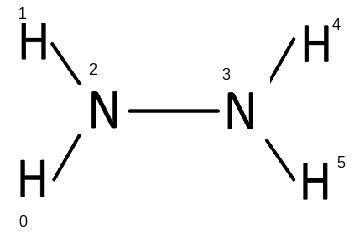



In [ ]:
### YOUR CODE BEGINS HERE
# 1. construct the edge index matrix
# 2. construct the node features matrix
# 3. construct the edge features matrix (see edge_attr attribute; scroll up)
# 4. construct the target matrix
# 5. create a `Data` object by invoking its constructor
### YOUR CODE ENDS HERE

### YOUR CODE BEGINS HERE
# print the data object and verify that the attributes and shapes makes sense
### YOUR CODE ENDS HERE

# Exploring common datasets

Just like `torch.utils.data.Dataset`, PyG datasets classes are derived from [`torch_geometric.data.Dataset`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Dataset) (which in turn derive from `torch.utils.data.Dataset)`. PyG provides a lot of common datasets off the shelf. 

### Cora

This dataset consists of a single citation network graph. The nodes are scientific publications and edges are citations. There are 2708 nodes and 5429 edges. Each publication is assigned a class that represents the topic/field of the publication. The node features are a boolean vector representing presence of a word from a vocabulary of 1433 words.

In [ ]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid("cora", name="Cora")

In [ ]:
print("type of object:", type(dataset))
print("class hierarchy of the dataset:", inspect.getmro(type(dataset)))

print("number of graphs:", len(dataset))
print("number of classes:", dataset.num_classes)
print("number of features:", dataset.num_features)
print("number of node features:", dataset.num_node_features)
print("number of edge featres:", dataset.num_edge_features)

In [ ]:
print(dataset.data)
print("type of object:", type(dataset.data))

In [ ]:
data = dataset[0]
print("type of object:", type(data))

### ENZYMES

ENZYMES is a dataset of 600 enzymes (molecular machines inside our cells that faciliate specific chemical reactions). Enzymes are essentially proteins which in turn are large macromolecules (large graphs for us). The task is to classify each enzyme into one of the six enzyme categories.

In [ ]:
from torch_geometric.datasets import TUDataset
dataset = TUDataset("enzymes", name="ENZYMES")

1. How many graphs are in the dataset?
2. How many classes are there?
3. How many node features are there?
4. How many edge features are there?

In [ ]:
### YOUR CODE BEGINS HERE

### YOUR CODE ENDS HERE

5. What is the label of the 100th graph in the dataset?
6. How many nodes and edges are present in the 25th graph?
7. Are the edges directed or undirected?

In [ ]:
### YOUR CODE BEGINS HERE

### YOUR CODE ENDS HERE

# Minibatches and DataLoaders

Neural networks are typially trained using minibatchs. Creating minibatches of graph data is relatively non-trivial. Minibatches are created by:
- concatenating adjacency matrices diagonally (to create a sparse block diagonal matrix)
- concatenating feature matrices in the node dimension into one gigantic feature matrix
- concatenating target matrices in the node dimension into one gigantic target matrix

$$$$

$$
\mathbf{A} = \begin{bmatrix} \mathbf{A}_1 & & \\ & \ddots & \\ & & \mathbf{A}_n \end{bmatrix}, \mathbf{X} = \begin{bmatrix} \mathbf{X}_1 \\ \vdots \\ \mathbf{X}_n \end{bmatrix}, \mathbf{E} = \begin{bmatrix} \mathbf{E}_1 \\ \vdots \\ \mathbf{E}_n \end{bmatrix}, \mathbf{Y} = \begin{bmatrix} \mathbf{Y}_1 \\ \vdots \\ \mathbf{Y}_n \end{bmatrix}
$$

$$$$

In a nutshell, we represent a minibatch of graphs as one gigantic disconnected graph.

We're aware that `torch.utils.data.DataLoader` provides facilities to automatially batch samples. PyG also provides an equivalent class with the same functionality: [`torch_geometric.loader.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.DataLoader).

`torch_geometric.loader.DataLoader` automatically takes care of the minibatching process. The data loader returns a [`Batch`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Batch) object. This object provides additional attributes: `num_graphs` and `batch`. The `num_graphs` attribute gives the number of graphs in the batch. The `batch` attribute of shape `[num_nodes, batch_idx]` maps nodes in the gigantic disconnected graph to their original graph.

$$\text{num_graphs} = n$$

$$\text{batch} = [0, 0, \ldots, 0, 1, 1, \ldots, \ldots, n - 1]^\mathbf{T}$$


In [ ]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
dataset = TUDataset("enzymes", name="ENZYMES")

dataset = dataset.shuffle()
training_dataset = dataset[:500]
validation_dataset = dataset[500:550]
test_dataset = dataset[550:600]

train_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True)

for batch in train_dataloader:
    print(type(batch))
    print("class hierarchy of the dataset:", inspect.getmro(type(batch)))
    print()
    print(batch.num_graphs)
    print(batch.batch)
    break

### Practice Problems
1. Compute the mean and standard deviation of node feature vectors in the batch.
2. Compute the mean of node feature vectors of each graph in the batch separately using [`torch.scatter_mean(node_features, data.batch, dim=?)`](https://pytorch-scatter.readthedocs.io/en/1.3.0/_modules/torch_scatter/mean.html).

In [ ]:
batch = next(iter(train_dataloader))
### YOUR CODE BEGINS HERE
# Problem 1

### YOUR CODE ENDS HERE

In [ ]:
### YOUR CODE BEGINS HERE
# Problem 2
from torch_scatter import scatter_mean
means = scatter_mean(batch.?, batch.?, dim=?)
print(means)
### YOUR CODE ENDS HERE

# Data Transforms

The dataset classes accept three arguments that transform or filter data points. The transforms accept (original graph) and return an object (transformed graph) of type `torch_geometric.data.Data`.
- `transform` : this transform is applied each time just before returning the data
- `pre_transform` : this transform is applied on every data once initially
- `pre_filter` : this function takes a `Data` object and returns whether it should be retained or thrown away; this is applied once initially


### Transforming ModelNet dataset

ModelNet is a dataset of 4,899 3D objects from 10 categories (3,991 training samples and 908 test samples). `torch_geometric.datasets.ModelNet` off the shelf without any transformations is a supplies the objects as meshes. Each data object stores the positions of the vertices (in the `pos` attribute) and indices of verticies that make each face (in the `face` attribute).


In [ ]:
from torch_geometric.datasets import ModelNet
dataset = ModelNet('modelnet', name='10', train=False, transform=None, pre_transform=None, pre_filter=None)

In [ ]:
print("Dataset:", dataset)
print("Sample:", dataset[0])

In [ ]:
data = dataset[0]

mesh = trimesh.Trimesh(vertices=data.pos, faces=data.face.T)
scene = trimesh.scene.Scene()
scene.add_geometry(mesh)
scene.show()

### Mesh to Point Ploud

PyG provides several builtin data transforms to manipulate graphs, meshes and point clouds. If we require point clouds, we can sample points from the mesh using the [`torch_geometric.transforms.SamplePoints`](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.SamplePoints) transform.

In [ ]:
from torch_geometric.datasets import ModelNet
dataset = ModelNet('modelnet', name='10', train=False, transform=torch_geometric.transforms.SamplePoints(num=1024))

In [ ]:
print(dataset[0])

### Practice Problem: Mesh to Graph

We require to convert meshes to graphs to train graph neural networks using PyG. Transform the dataset to supply graphs instead of meshes using [torch_geometric.transforms.FaceToEdge](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.FaceToEdge) transform.

In [ ]:
### YOUR CODE BEGINS HERE
dataset =
### YOUR CODE ENDS HERE

In [ ]:
print(dataset[0])

# Implementing GCN and EdgeConv

Implement [GCNConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) layer from scratch by reading [Creating Message Passing Networks](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html).

In [ ]:
from torch_geometric.nn import MessagePassing

class GCNConv(MessagePassing):
    pass

Implement [EdgeConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.EdgeConv) layer from scratch by reading [Creating Message Passing Networks](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html).

In [ ]:
class EdgeConv(MessagePassing):
  pass

# Node classification on Cora

This dataset consists of a single graph where nodes are scientific publications. There are 2708 publications and 5429 edges. Each publication is assigned a class that represents the topic/field of the publication. The node features are a boolean vector representing presence of a word from a vocabulary of 1433 words.

**Problem Statement:**
The task here is to classify every scientific publication (node) into one of the seven topics/fields (class). During training, only classes of certain nodes are used. The predictions for the remaining nodes are used for validation and testing. The dataset provides the train, validation and test masks. 

![Cora Visualization](https://production-media.paperswithcode.com/datasets/Cora-0000000700-ce1c5ec7_LD7pZnT.jpg)

In [ ]:
dataset = Planetoid(root="cora", name= "Cora")

In [ ]:
print("number of graphs:", len(dataset))
print("number of classes:", dataset.num_classes)
print("number of features:", dataset.num_features)
print("number of node features:", dataset.num_node_features)
print("number of edge featres:", dataset.num_edge_features)

In [ ]:
print(dataset.data)

In [ ]:
class CoraNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = gnn.GCNConv(dataset.num_features, 32)

        ### YOUR CODE BEGINS HERE
        # Add a SAGEConv layer with 'max' as the aggregation function
        self.conv2 = 

        # Add few more layers if you wish (more convs, dropout, etc) but you should output 'dataset.num_classes' logits at the end
        ### YOUR CODE ENDS HERE

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        
        ### YOUR CODE BEGINS HERE
        # relu -> conv2 -> ...
        
        ### YOUR CODE ENDS HERE

        return F.log_softmax(x, dim=1)

In [ ]:
def train(model, data, optimizer, criterion):
    model.train()
    ### YOUR CODE BEGINS HERE
    # 1. zero existing gradients
    # 2. forward the graph
    # 3. compute the loss (use output[data.train_mask] and data.y[data.train_mask] to compute loss on training nodes only)
    # 4. backprop the loss
    # 5. update the weights

    ### YOUR CODE ENDS HERE
    return loss.item()

def test(model, data, mask, criterion):
    model.eval()
    ### YOUR CODE BEGINS HERE
    # 1. forward the graph
    # 2. find labels for the nodes in the mask (output[mask]?)

    ### YOUR CODE ENDS HERE
    return (predicted_class == data.y[mask]).sum()/ mask.sum()

In [ ]:
model = CoraNet().to(device=device)
data = dataset.data.to(device=device)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val_accuracy = 0
for epoch in range(50):
  train_loss = train(model, data, optimizer, criterion)  
  val_accuracy = test(model, data, data.val_mask, criterion)

  if val_accuracy > best_val_accuracy:
    print("new best model")
    torch.save(model.state_dict(), "best_cora_model.pth")
    best_val_accuracy = val_accuracy

  print("[%d] training loss: %.3f" % (epoch + 1, train_loss))
  print("[%d] validation >> accuracy: %.2f%%" % (epoch + 1, val_accuracy * 100))
  print()

In [ ]:
model.load_state_dict(torch.load("best_cora_model.pth"))

test_accuracy = test(model, data, data.test_mask, criterion)
print("test accuracy:", test_accuracy.item() * 100)

Visit [Node Classification on Cora Leaderboard](https://paperswithcode.com/sota/node-classification-on-cora). Compare your model's perform against the top performing models.

Using [PyG documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers), alter the model architecture to surpass 75%. You don't need to understand the details thoroughly; use the layers as black boxes.